In [1]:
# Paquetes

import numpy
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import (
        train_test_split,
        learning_curve,
        StratifiedKFold,
        cross_val_score
        )
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import unidecode
from functions_model import plots_freq_target,prepare_datasets,prepare_datasets_sinseg,get_file,plot_ROC,plot_confusion_matrix
from functions_model import plot_learning_curve,plot_ROC_kfolds

import os
import s3fs
import pyarrow.parquet as pq
import json
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, mean_squared_error, roc_auc_score, precision_score 
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
#import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import xgboost as xgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# Definir parámetros
params_dict = {'min_percent_leaf': 0.05,
               'input_path':'s3://adl-refined-dev-popular/parquet/TC_adquisicion/total_tdc_paprob',
               'output_path':'/mnt/work/CU_adquisicionTC/Notebooks/creacion modelo/resultados_arbolV0/',
               'segment_name':'preaprobados'}

In [3]:
fs = s3fs.S3FileSystem()

# Leyendo base
input = params_dict['input_path']
dataset = pq.ParquetDataset(input, filesystem=fs)
table = dataset.read()
mdt = table.to_pandas()

del input, dataset, table

# Definiendo Var Obj'var_final'etivo
y_var = '30first_use'

In [4]:
mdt.shape

(35614, 1559)

In [5]:
mdt.columns

Index(['id_cliente', 'fecha_tx_pav', 'fecha_tx_act', 'fecha_pasivo',
       'fecha_lib', 'fecha_activo', 'fecha_buro', 'data_camp', 'mes_campaña',
       'venta',
       ...
       'prom_mov_ult_3meses_ahr', 'prom_mov_ult_4meses_ahr',
       'prom_mov_ult_6meses_ahr', 'mode_dia_ahr', 'estado_cta_actual_ahr',
       'tipo_transaccion_ahr', 'sum_tx_linea_ahr', 'sum_tx_nolinea_ahr',
       'fecha_ult_tx_ahr', 'dias_desde_ult_tx_ahr'],
      dtype='object', length=1559)

In [ ]:
mdt.head()

In [6]:
cliente = mdt.groupby(['data_camp','id_cliente'])['id_cliente'].count()
cliente

data_camp  id_cliente        
201902     102652298385292701    1
           102652298438428901    1
           102652309828978401    1
           102652310094430101    1
           102652310173842601    1
           102652310441387401    1
           102652317101191101    1
           103552296423272102    1
           103552299058754302    1
           103552299197358602    1
           103552303103281702    1
           103552303307435502    1
           103552303943127002    1
           103552308279771902    1
           103552314680390702    1
           103554869096415001    1
           105655266672835301    1
           108553313753904301    1
           111853304361244101    1
           113154264617949901    1
           116552294429418602    1
           116552295019943402    1
           116552296697603302    1
           116552297846687902    1
           116552299071681302    1
           116552299072942802    1
           116552306135897602    1
           11655230743185

In [ ]:
cliente.shape

In [7]:
np.random.seed(seed=4321) # Semilla
## Muestra del 50%
#Se generan numeros aleatorios entre 0 y 1
#mdt['ran']=np.random.random(size=mdt.shape[0])

#Se seleccion train : 50% 
mdt_v0=mdt.copy()

# quitando otras variables VO
mdt_v0.drop(columns=['var_final','mes_campaña','venta', 'fecha_activo', 'fecha_buro', 'fecha_data', 'fecha_envio',
                     'tipo_campana', 'periodo','cedulaenc','tipo_cliente','tipo_id','derogatorio',
                     'fecha_real','fecha_mas_antigua_apertura','timestamp','lag_t_6_saldo_tot_tot_SMLV', 
                     'lag_t_1_cuota_tot_LB_SMLV', 'lag_t_6_cuota_tot_LB_SMLV', 'lag_t_6_cuota_tot_tot_SMLV', 
                     'lag_t_1_amortizacion_prom_LB', 'lag_t_6_amortizacion_prom_LB', 'lag_t_1_amortizacion_prom_tot', 
                     'lag_t_6_amortizacion_prom_tot', 'lag_t_6_saldo_tot_LB_SMLV', 'lag_t_1_saldo_tot_tot_SMLV', 
                     'lag_t_1_cuota_tot_tot_SMLV', 'lag_t_6_cupo_tot_LB_SMLV', 'lag_t_1_cupo_tot_tot_SMLV', 'lag_t_6_cupo_tot_tot_SMLV'], inplace = True)

In [ ]:
mdt_v0.shape

In [8]:
## Vars modelo:

top_vars = [
'acierta_a_financiero',
'acep_oferta_prev',
'amortizacion_max_LB',
'amortizacion_max_tot',
'amortizacion_min_LB',
'amortizacion_min_tot',
'amortizacion_prom_LB',
'amortizacion_prom_LB_ult3_meses',
'amortizacion_prom_LB_ult9_meses',
'amortizacion_prom_tot',
'amortizacion_prom_tot_ult3_meses',
'amortizacion_prom_tot_ult9_meses',
'ano_po',
'antiguedad_tot_conlibranza',
'cartera_banca_alt_max_de_mora_was_is',
'cartera_coope_alt_max_de_mora_was_is',
'cartera_hipote_alt_max_de_mora_was_is',
'ctas_de_ahorro_act_ctas_bancadif',
'cuota_max_LB_SMLV',
'cuota_max_tot_SMLV',
'cuota_paga_prom_ult3_meses_total',
'cuota_paga_prom_ult7_meses_total',
'cuota_prom_LB_SMLV',
'cuota_prom_tot_SMLV',
'cuota_tot_LB_SMLV',
'cuota_tot_LB_SMLV_ult3_meses',
'cuota_tot_LB_SMLV_ult8_meses',
'cuota_tot_tot_SMLV',
'cuota_tot_tot_SMLV_ult3_meses',
'cuota_tot_tot_SMLV_ult8_meses',
'cuota_mercado_smlv',
'cupo_max_LB_SMLV',
'cupo_max_tot_SMLV',
'cupo_mercadodif',
'cupo_prom_LB_SMLV',
'cupo_prom_tot_SMLV',
'cupo_tot_LB_SMLV',
'cupo_tot_LB_SMLV_ult3_meses',
'cupo_tot_LB_SMLV_ult9_meses',
'cupo_tot_tot_SMLV',
'cupo_tot_tot_SMLV_ult3_meses',
'cupo_tot_tot_SMLV_ult9_meses',
'cuposectorbancario_sin_popular_smlv',
'dias_desde_ult_tx_ahr',
'dias_desde_ult_tx_cdt',
'dias_desde_ult_tx_cte',
'dias_desde_ult_tx_pasv',
'dif_porc_t_1_amortizacion_prom_LB',
'dif_porc_t_1_amortizacion_prom_tot',
'dif_porc_t_6_amortizacion_prom_LB',
'dif_porc_t_6_amortizacion_prom_tot',
'dif_porc_t_6_saldo_tot_tot_SMLV',
'estado_cta_actual_ahr',
'estado_cta_actual_cdt',
'estado_cta_actual_cte',
'estado_cta_actual_pasv',
'fec_mas_anti_aper_tdc_sin_popu',
'fecantiapersectorbancasinpopu',
'lag_t_1_cupo_tot_LB_SMLV',
'lag_t_1_saldo_tot_LB_SMLV',
'marca_derogatorio',
'max_cupo_tdc_sin_populardif',
'max_dias_procesamiento',
'maxcuposectorbancasin_popular_smlv',
'meses_ultim_aper_LB',
'meses_ultim_aper_tot',
'mode_dia_ahr',
'mode_dia_cdt',
'mode_dia_cte',
'mode_dia_pasv',
'moramax_mercado_was_is',
'n_novaciones',
'num_act_utl_meses',
'num_aper_ultim_12meses_LB',
'num_aper_ultim_12meses_tot',
'num_aper_ultim_6meses_LB',
'num_aper_ultim_6meses_tot',
'num_camp_ult_meses',
'num_lib_solicitadas',
'num_meses_ult_camp',
'num_no_aceptado',
'num_tx_ult_1mes_ahr',
'num_tx_ult_1mes_cdt',
'num_tx_ult_1mes_cte',
'num_tx_ult_1mes_pasv',
'num_tx_ult_2meses_ahr',
'num_tx_ult_2meses_cdt',
'num_tx_ult_2meses_cte',
'num_tx_ult_2meses_pasv',
'num_tx_ult_3meses_ahr',
'num_tx_ult_3meses_cdt',
'num_tx_ult_3meses_cte',
'num_tx_ult_3meses_pasv',
'num_tx_ult_4meses_ahr',
'num_tx_ult_4meses_cdt',
'num_tx_ult_4meses_cte',
'num_tx_ult_4meses_pasv',
'num_tx_ult_6meses_ahr',
'num_tx_ult_6meses_cdt',
'num_tx_ult_6meses_cte',
'num_tx_ult_6meses_pasv',
'numero_creditos_cf',
'numero_creditos_codeudores',
'numero_obligaciones_activasdif',
'numoblvigensectorbancasin_popu',
'pasv_antig_total',
'pasv_dias_desde_ultima_trans',
'pasv_num_ctas_vig_ca',
'pasv_num_ctas_vig_cc',
'pasv_num_ctas_vig_cdt',
'pasv_num_ctas_vig_tot',
'pasv_num_meses_ult_apertura',
'pasv_saldo_ca_1mes_atras',
'pasv_saldo_ca_3mes_atras',
'pasv_saldo_ca_6mes_atras',
'pasv_saldo_ca_fin_mes_smlv',
'pasv_saldo_cc_1mes_atras',
'pasv_saldo_cc_3mes_atras',
'pasv_saldo_cc_6mes_atras',
'pasv_saldo_cc_fin_mes_smlv',
'pasv_saldo_cdt_1mes_atras',
'pasv_saldo_cdt_3mes_atras',
'pasv_saldo_cdt_6mes_atras',
'pasv_saldo_cdt_fin_mes_smlv',
'pasv_saldo_max_ca_fin_mes_smlv',
'pasv_saldo_max_cc_fin_mes_smlv',
'pasv_saldo_max_cdt_fin_mes_smlv',
'pasv_saldo_max_fin_mes_smlv',
'pasv_saldo_min_ca_fin_mes_smlv',
'pasv_saldo_min_cc_fin_mes_smlv',
'pasv_saldo_min_cdt_fin_mes_smlv',
'pasv_saldo_min_fin_mes_smlv',
'pasv_saldo_tot_fin_mes_smlv',
'pasv_saldo_total_1mes_atras',
'pasv_saldo_total_3mes_atras',
'pasv_saldo_total_6mes_atras',
'peor_calif_trim_2_endeud',
'peor_califi_trim_1_endeud',
'prom_dias_procesamiento',
'prom_monto_aprobado',
'prom_monto_desembolsado',
'prom_monto_novado',
'prom_monto_solicitado',
'prom_n_cuotas',
'prom_prop_desembolso',
'prom_tasa',
'prom_tx_ult_1meses_ahr',
'prom_tx_ult_1meses_cdt',
'prom_tx_ult_1meses_cte',
'prom_tx_ult_1meses_pasv',
'prom_tx_ult_2meses_ahr',
'prom_tx_ult_2meses_cdt',
'prom_tx_ult_2meses_cte',
'prom_tx_ult_2meses_pasv',
'prom_tx_ult_3meses_ahr',
'prom_tx_ult_3meses_cdt',
'prom_tx_ult_3meses_cte',
'prom_tx_ult_3meses_pasv',
'prom_tx_ult_4meses_ahr',
'prom_tx_ult_4meses_cdt',
'prom_tx_ult_4meses_cte',
'prom_tx_ult_4meses_pasv',
'prom_tx_ult_6meses_ahr',
'prom_tx_ult_6meses_cdt',
'prom_tx_ult_6meses_cte',
'prom_tx_ult_6meses_pasv',
'prom_valor_cuota',
'promcuposectorbancasin_popular_smlv',
'quanto_mod',
'rango_2',
'rango_4',
'rango_5',
'saldo_max_LB_SMLV',
'saldo_max_tot_SMLV',
'saldo_prom_LB_SMLV',
'saldo_prom_tot_SMLV',
'saldo_prom_ult3_meses_total',
'saldo_prom_ult6_meses_total',
'saldo_prom_ult7_meses_total',
'saldo_tot_LB_SMLV',
'saldo_tot_LB_SMLV_ult3_meses',
'saldo_tot_LB_SMLV_ult7_meses',
'saldo_tot_tot_SMLV',
'saldo_tot_tot_SMLV_ult3_meses',
'saldo_tot_tot_SMLV_ult7_meses',
'sector_ultlibranza',
'subsector_ultlibranza',
'sum_tx_linea_ahr',
'sum_tx_linea_cte',
'sum_tx_linea_pasv',
'sum_tx_nolinea_ahr',
'sum_tx_nolinea_cdt',
'sum_tx_nolinea_pasv',
'tdc_altura_maxima_de_mora_was_is',
'tiene_cartfinanciera',
'tiene_codeudor',
'tiene_sectorreal',
'tipo_pagaduria_ultlibranza',
'tipo_transaccion',
'tipo_transaccion_ahr',
'tipo_transaccion_cdt',
'tipo_transaccion_cte',
'utilizacion_sin_popular',
'util_prom_ult3_meses_total',
'util_prom_ult6_meses_total',
'util_prom_ult9_meses_total',
'util_sector_banca_sin_popular',
'val_cuo_sector_banca_sin_popu',
'valor_cuotas_cbdif',
'valor_cuotas_codeudores_smlv',
'valor_cuotas_sr_smlv',
'valor_inicial_cbdif',
'valor_inicial_cf_smlv',
'valor_saldo_codeudores_smlv',
'valor_saldo_cbdif',
'valor_saldo_srdif',
'valor_saldo_sr_smlv',
'valor_utilisectorbancasin_popu_smlv',
'valor_utilisectorbancasin_popudif',
'valor_utilizado_smlv',
'valor_utilizadodif',
'was_is_CC',
'was_is_CE',
'was_is_CH',
'was_is_LB',
'was_is_LE',
'was_is_ME',
'was_is_NV',
'was_is_SO',
'was_is_TC',
'was_is_TC_T',
'was_is_TC_X',
'porcentaje_utilizacion'
]

In [9]:
mdt_v0 = mdt_v0[['id_cliente','30first_use']+top_vars]

In [10]:
mdt_v0['num_nulos'] = mdt_v0.apply(lambda row: (row.isnull()).sum(), axis=1)
mdt_v0 = mdt_v0[mdt_v0['num_nulos']<50]

In [11]:
mdt['30first_use'].value_counts(normalize=True)*100

0    95.63374
1     4.36626
Name: 30first_use, dtype: float64

In [12]:
mdt_v0['30first_use'].value_counts(normalize=True)*100

0    95.118285
1     4.881715
Name: 30first_use, dtype: float64

In [13]:
mdt_v0.set_index(['id_cliente'], inplace=True)

In [14]:
#feature engineering

mdt_v0['peor_califi_trim_1_endeud_cat'] = (mdt_v0['peor_califi_trim_1_endeud'] == 'mantiene').astype('int')
mdt_v0['peor_calif_trim_2_endeud_cat'] = (mdt_v0['peor_calif_trim_2_endeud'] == 'mantiene').astype('int')
mdt_v0['marca_derogatorio_cat'] = (mdt_v0['marca_derogatorio'] == 'aprobado').astype('int')
mdt_v0['tdc_altura_maxima_de_mora_was_is_cat'] = (mdt_v0['tdc_altura_maxima_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['cartera_banca_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_banca_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['cartera_coope_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_coope_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['cartera_hipote_alt_max_de_mora_was_is_cat'] = (mdt_v0['cartera_hipote_alt_max_de_mora_was_is'] == 'mantiene').astype('int')
mdt_v0['moramax_mercado_was_is_cat'] = (mdt_v0['moramax_mercado_was_is'] == 'mantiene').astype('int')
mdt_v0['was_is_LB_cat'] = (mdt_v0['was_is_LB'] == 'mantiene').astype('int')
mdt_v0['was_is_TC_cat'] = (mdt_v0['was_is_TC'] == 'mantiene').astype('int')
mdt_v0['was_is_NV_cat'] = (mdt_v0['was_is_NV'] == 'mantiene').astype('int')
mdt_v0['was_is_CH_cat'] = (mdt_v0['was_is_CH'] == 'mantiene').astype('int')
mdt_v0['was_is_CE_cat'] = (mdt_v0['was_is_CE'] == 'mantiene').astype('int')
mdt_v0['was_is_LE_cat'] = (mdt_v0['was_is_LE'] == 'mantiene').astype('int')
mdt_v0['was_is_ME_cat'] = (mdt_v0['was_is_ME'] == 'mantiene').astype('int')
mdt_v0['was_is_SO_cat'] = (mdt_v0['was_is_SO'] == 'mantiene').astype('int')
mdt_v0['was_is_CC_cat'] = (mdt_v0['was_is_CC'] == 'mantiene').astype('int')
mdt_v0['was_is_TC_X_cat'] = (mdt_v0['was_is_TC_X'] == 'mantiene').astype('int')
mdt_v0['was_is_TC_T_cat'] = (mdt_v0['was_is_TC_T'] == 'mantiene').astype('int')
mdt_v0['tipo_transaccion_cat'] = (mdt_v0['tipo_transaccion'] == '2').astype('int')
mdt_v0['tipo_transaccion_ahr_cat'] = (mdt_v0['tipo_transaccion_ahr'] == '2').astype('int')
mdt_v0['tipo_transaccion_cdt_cat'] = (mdt_v0['tipo_transaccion_cdt'] == '2').astype('int')
mdt_v0['tipo_transaccion_cte_cat'] = (mdt_v0['tipo_transaccion_cte'] == '2').astype('int')

In [15]:
y= ['30first_use']

var_numericas = [
'acep_oferta_prev',
'acierta_a_financiero',
'amortizacion_max_LB',
'amortizacion_max_tot',
'amortizacion_min_LB',
'amortizacion_min_tot',
'amortizacion_prom_LB',
'amortizacion_prom_LB_ult3_meses',
'amortizacion_prom_LB_ult9_meses',
'amortizacion_prom_tot',
'amortizacion_prom_tot_ult3_meses',
'amortizacion_prom_tot_ult9_meses',
'ano_po',
'antiguedad_tot_conlibranza',
'ctas_de_ahorro_act_ctas_bancadif',
'cuota_max_LB_SMLV',
'cuota_max_tot_SMLV',
'cuota_mercado_smlv',
'cuota_paga_prom_ult3_meses_total',
'cuota_paga_prom_ult7_meses_total',
'cuota_prom_LB_SMLV',
'cuota_prom_tot_SMLV',
'cuota_tot_LB_SMLV',
'cuota_tot_LB_SMLV_ult3_meses',
'cuota_tot_LB_SMLV_ult8_meses',
'cuota_tot_tot_SMLV',
'cuota_tot_tot_SMLV_ult3_meses',
'cuota_tot_tot_SMLV_ult8_meses',
'cupo_max_LB_SMLV',
'cupo_max_tot_SMLV',
'cupo_mercadodif',
'cupo_prom_LB_SMLV',
'cupo_prom_tot_SMLV',
'cupo_tot_LB_SMLV',
'cupo_tot_LB_SMLV_ult3_meses',
'cupo_tot_LB_SMLV_ult9_meses',
'cupo_tot_tot_SMLV',
'cupo_tot_tot_SMLV_ult3_meses',
'cupo_tot_tot_SMLV_ult9_meses',
'cuposectorbancario_sin_popular_smlv',
'dias_desde_ult_tx_ahr',
'dias_desde_ult_tx_cdt',
'dias_desde_ult_tx_cte',
'dias_desde_ult_tx_pasv',
'dif_porc_t_1_amortizacion_prom_LB',
'dif_porc_t_1_amortizacion_prom_tot',
'dif_porc_t_6_amortizacion_prom_LB',
'dif_porc_t_6_amortizacion_prom_tot',
'dif_porc_t_6_saldo_tot_tot_SMLV',
'fec_mas_anti_aper_tdc_sin_popu',
'fecantiapersectorbancasinpopu',
'lag_t_1_cupo_tot_LB_SMLV',
'lag_t_1_saldo_tot_LB_SMLV',
'max_cupo_tdc_sin_populardif',
'max_dias_procesamiento',
'maxcuposectorbancasin_popular_smlv',
'meses_ultim_aper_LB',
'meses_ultim_aper_tot',
'n_novaciones',
'num_act_utl_meses',
'num_aper_ultim_12meses_LB',
'num_aper_ultim_12meses_tot',
'num_aper_ultim_6meses_LB',
'num_aper_ultim_6meses_tot',
'num_camp_ult_meses',
'num_lib_solicitadas',
'num_meses_ult_camp',
'num_no_aceptado',
'num_tx_ult_1mes_ahr',
'num_tx_ult_1mes_cdt',
'num_tx_ult_1mes_cte',
'num_tx_ult_1mes_pasv',
'num_tx_ult_2meses_ahr',
'num_tx_ult_2meses_cdt',
'num_tx_ult_2meses_cte',
'num_tx_ult_2meses_pasv',
'num_tx_ult_3meses_ahr',
'num_tx_ult_3meses_cdt',
'num_tx_ult_3meses_cte',
'num_tx_ult_3meses_pasv',
'num_tx_ult_4meses_ahr',
'num_tx_ult_4meses_cdt',
'num_tx_ult_4meses_cte',
'num_tx_ult_4meses_pasv',
'num_tx_ult_6meses_ahr',
'num_tx_ult_6meses_cdt',
'num_tx_ult_6meses_cte',
'num_tx_ult_6meses_pasv',
'numero_creditos_cf',
'numero_creditos_codeudores',
'numero_obligaciones_activasdif',
'numoblvigensectorbancasin_popu',
'pasv_antig_total',
'pasv_dias_desde_ultima_trans',
'pasv_num_ctas_vig_ca',
'pasv_num_ctas_vig_cc',
'pasv_num_ctas_vig_cdt',
'pasv_num_ctas_vig_tot',
'pasv_num_meses_ult_apertura',
'pasv_saldo_ca_1mes_atras',
'pasv_saldo_ca_3mes_atras',
'pasv_saldo_ca_6mes_atras',
'pasv_saldo_ca_fin_mes_smlv',
'pasv_saldo_cc_1mes_atras',
'pasv_saldo_cc_3mes_atras',
'pasv_saldo_cc_6mes_atras',
'pasv_saldo_cc_fin_mes_smlv',
'pasv_saldo_cdt_1mes_atras',
'pasv_saldo_cdt_3mes_atras',
'pasv_saldo_cdt_6mes_atras',
'pasv_saldo_cdt_fin_mes_smlv',
'pasv_saldo_max_ca_fin_mes_smlv',
'pasv_saldo_max_cc_fin_mes_smlv',
'pasv_saldo_max_cdt_fin_mes_smlv',
'pasv_saldo_max_fin_mes_smlv',
'pasv_saldo_min_ca_fin_mes_smlv',
'pasv_saldo_min_cc_fin_mes_smlv',
'pasv_saldo_min_cdt_fin_mes_smlv',
'pasv_saldo_min_fin_mes_smlv',
'pasv_saldo_tot_fin_mes_smlv',
'pasv_saldo_total_1mes_atras',
'pasv_saldo_total_3mes_atras',
'pasv_saldo_total_6mes_atras',
'porcentaje_utilizacion',
'prom_dias_procesamiento',
'prom_monto_aprobado',
'prom_monto_desembolsado',
'prom_monto_novado',
'prom_monto_solicitado',
'prom_n_cuotas',
'prom_prop_desembolso',
'prom_tasa',
'prom_tx_ult_1meses_ahr',
'prom_tx_ult_1meses_cdt',
'prom_tx_ult_1meses_cte',
'prom_tx_ult_1meses_pasv',
'prom_tx_ult_2meses_ahr',
'prom_tx_ult_2meses_cdt',
'prom_tx_ult_2meses_cte',
'prom_tx_ult_2meses_pasv',
'prom_tx_ult_3meses_ahr',
'prom_tx_ult_3meses_cdt',
'prom_tx_ult_3meses_cte',
'prom_tx_ult_3meses_pasv',
'prom_tx_ult_4meses_ahr',
'prom_tx_ult_4meses_cdt',
'prom_tx_ult_4meses_cte',
'prom_tx_ult_4meses_pasv',
'prom_tx_ult_6meses_ahr',
'prom_tx_ult_6meses_cdt',
'prom_tx_ult_6meses_cte',
'prom_tx_ult_6meses_pasv',
'prom_valor_cuota',
'promcuposectorbancasin_popular_smlv',
'quanto_mod',
'rango_2',
'rango_4',
'rango_5',
'saldo_max_LB_SMLV',
'saldo_max_tot_SMLV',
'saldo_prom_LB_SMLV',
'saldo_prom_tot_SMLV',
'saldo_prom_ult3_meses_total',
'saldo_prom_ult6_meses_total',
'saldo_prom_ult7_meses_total',
'saldo_tot_LB_SMLV',
'saldo_tot_LB_SMLV_ult3_meses',
'saldo_tot_LB_SMLV_ult7_meses',
'saldo_tot_tot_SMLV',
'saldo_tot_tot_SMLV_ult3_meses',
'saldo_tot_tot_SMLV_ult7_meses',
'sum_tx_linea_ahr',
'sum_tx_linea_cte',
'sum_tx_linea_pasv',
'sum_tx_nolinea_ahr',
'sum_tx_nolinea_cdt',
'sum_tx_nolinea_pasv',
'tiene_cartfinanciera',
'tiene_codeudor',
'tiene_sectorreal',
'util_prom_ult3_meses_total',
'util_prom_ult6_meses_total',
'util_prom_ult9_meses_total',
'util_sector_banca_sin_popular',
'utilizacion_sin_popular',
'val_cuo_sector_banca_sin_popu',
'valor_cuotas_cbdif',
'valor_cuotas_codeudores_smlv',
'valor_cuotas_sr_smlv',
'valor_inicial_cbdif',
'valor_inicial_cf_smlv',
'valor_saldo_cbdif',
'valor_saldo_codeudores_smlv',
'valor_saldo_sr_smlv',
'valor_saldo_srdif',
'valor_utilisectorbancasin_popu_smlv',
'valor_utilisectorbancasin_popudif',
'valor_utilizado_smlv',
'valor_utilizadodif'
]

var_binarias = [
'peor_califi_trim_1_endeud_cat',
'peor_calif_trim_2_endeud_cat',
'marca_derogatorio_cat',
'tdc_altura_maxima_de_mora_was_is_cat',
'cartera_banca_alt_max_de_mora_was_is_cat',
'cartera_coope_alt_max_de_mora_was_is_cat',
'cartera_hipote_alt_max_de_mora_was_is_cat',
'moramax_mercado_was_is_cat',
'was_is_LB_cat',
'was_is_TC_cat',
'was_is_NV_cat',
'was_is_CH_cat',
'was_is_CE_cat',
'was_is_LE_cat',
'was_is_ME_cat',
'was_is_SO_cat',
'was_is_CC_cat',
'was_is_TC_X_cat',
'was_is_TC_T_cat',
'tipo_transaccion_cat',
'tipo_transaccion_ahr_cat',
'tipo_transaccion_cdt_cat',
'tipo_transaccion_cte_cat'
]

var_nominales = [
'estado_cta_actual_ahr',
'estado_cta_actual_cdt',
'estado_cta_actual_cte',
'estado_cta_actual_pasv',
'mode_dia_ahr',
'mode_dia_cdt',
'mode_dia_cte',
'mode_dia_pasv',
'sector_ultlibranza',
'tipo_pagaduria_ultlibranza'
]

In [16]:
# Fill missing con categoria 'missing' para variables categoricas existentes

mdt_v0[var_nominales] = mdt_v0[var_nominales].apply(lambda x: x.fillna('missing'))

In [17]:
# Fill missing con 0 para variables de Tenencia

mdt_v0[var_binarias] = mdt_v0[var_binarias].apply(lambda x: x.fillna(0.0).astype(float))

In [18]:
# Casteo de variables númericas a flotantes 

mdt_v0[var_numericas] = mdt_v0[var_numericas].apply(lambda x: round(x.astype(float),2))

In [19]:
# Acotación de valores extremos unicamente para las variables númericas que aplican

for col in var_numericas:
#     #df_train[col] = np.where(df_train[col]==np.PINF,df_train.loc[df_train[col]!=np.PINF,col].max(),df_train[col])
#     mdt_v0[col] = np.where(mdt_v0[col]==np.PINF,
#                                  next(mdt_v0[col].quantile(i) for i in np.arange(1,0.9,-0.01) if 
#                                       mdt_v0[col].quantile(i)!=np.PINF and ~np.isnan(mdt_v0[col].quantile(i))),
#                                          mdt_v0[col])
    
#     #df_train[col] = np.where(df_train[col]==np.NINF,df_train.loc[df_train[col]!=np.NINF,col].min(),df_train[col])
#     mdt_v0[col] = np.where(mdt_v0[col]==np.NINF,
#                                  next(mdt_v0[col].quantile(i) for i in np.arange(0,0.1,0.01) if 
#                                       mdt_v0[col].quantile(i)!=np.NINF and ~np.isnan(mdt_v0[col].quantile(i))),
#                                          mdt_v0[col])
    
    mdt_v0[col] = np.where(mdt_v0[col] >= mdt_v0[col].quantile(0.99),round(mdt_v0[col].quantile(0.99),2),
                     np.where(mdt_v0[col] <= mdt_v0[col].quantile(0.01),round(mdt_v0[col].quantile(0.01),2),
                              mdt_v0[col]))

In [20]:
mdt_v0.values

array([[0, 842.0, 0.0, ..., 1.0, 0.0, 0.0],
       [0, 721.0, 0.0, ..., 1.0, 0.0, 0.0],
       [0, 860.0, 0.0, ..., 0.0, 0.0, 0.0],
       ...,
       [0, 771.0, nan, ..., 1.0, 0.0, 0.0],
       [0, 747.0, nan, ..., 0.0, 0.0, 0.0],
       [0, 682.0, nan, ..., 1.0, 0.0, 0.0]], dtype=object)

In [21]:
mdt_v0.dtypes

30first_use                                    int64
acierta_a_financiero                         float64
acep_oferta_prev                             float64
amortizacion_max_LB                          float64
amortizacion_max_tot                         float64
amortizacion_min_LB                          float64
amortizacion_min_tot                         float64
amortizacion_prom_LB                         float64
amortizacion_prom_LB_ult3_meses              float64
amortizacion_prom_LB_ult9_meses              float64
amortizacion_prom_tot                        float64
amortizacion_prom_tot_ult3_meses             float64
amortizacion_prom_tot_ult9_meses             float64
ano_po                                       float64
antiguedad_tot_conlibranza                   float64
cartera_banca_alt_max_de_mora_was_is          object
cartera_coope_alt_max_de_mora_was_is          object
cartera_hipote_alt_max_de_mora_was_is         object
ctas_de_ahorro_act_ctas_bancadif             f

In [22]:
mdt_v0.head()

,30first_use,acierta_a_financiero,acep_oferta_prev,amortizacion_max_LB,amortizacion_max_tot,amortizacion_min_LB,amortizacion_min_tot,amortizacion_prom_LB,amortizacion_prom_LB_ult3_meses,amortizacion_prom_LB_ult9_meses,amortizacion_prom_tot,amortizacion_prom_tot_ult3_meses,amortizacion_prom_tot_ult9_meses,ano_po,antiguedad_tot_conlibranza,cartera_banca_alt_max_de_mora_was_is,cartera_coope_alt_max_de_mora_was_is,cartera_hipote_alt_max_de_mora_was_is,ctas_de_ahorro_act_ctas_bancadif,cuota_max_LB_SMLV,cuota_max_tot_SMLV,cuota_paga_prom_ult3_meses_total,cuota_paga_prom_ult7_meses_total,cuota_prom_LB_SMLV,cuota_prom_tot_SMLV,cuota_tot_LB_SMLV,cuota_tot_LB_SMLV_ult3_meses,cuota_tot_LB_SMLV_ult8_meses,cuota_tot_tot_SMLV,cuota_tot_tot_SMLV_ult3_meses,cuota_tot_tot_SMLV_ult8_meses,cuota_mercado_smlv,cupo_max_LB_SMLV,cupo_max_tot_SMLV,cupo_mercadodif,cupo_prom_LB_SMLV,cupo_prom_tot_SMLV,cupo_tot_LB_SMLV,cupo_tot_LB_SMLV_ult3_meses,cupo_tot_LB_SMLV_ult9_meses,cupo_tot_tot_SMLV,cupo_tot_tot_SMLV_ult3_meses,cupo_tot_tot_SMLV_ult9_meses,cuposectorbancario_sin_popular_smlv,dias_desde_ult_tx_ahr,dias_desde_ult_tx_cdt,dias_desde_ult_tx_cte,dias_desde_ult_tx_pasv,dif_porc_t_1_amortizacion_prom_LB,dif_porc_t_1_amortizacion_prom_tot,dif_porc_t_6_amortizacion_prom_LB,dif_porc_t_6_amortizacion_prom_tot,dif_porc_t_6_saldo_tot_tot_SMLV,estado_cta_actual_ahr,estado_cta_actual_cdt,estado_cta_actual_cte,estado_cta_actual_pasv,fec_mas_anti_aper_tdc_sin_popu,fecantiapersectorbancasinpopu,lag_t_1_cupo_tot_LB_SMLV,lag_t_1_saldo_tot_LB_SMLV,marca_derogatorio,max_cupo_tdc_sin_populardif,max_dias_procesamiento,maxcuposectorbancasin_popular_smlv,meses_ultim_aper_LB,meses_ultim_aper_tot,mode_dia_ahr,mode_dia_cdt,mode_dia_cte,mode_dia_pasv,moramax_mercado_was_is,n_novaciones,num_act_utl_meses,num_aper_ultim_12meses_LB,num_aper_ultim_12meses_tot,num_aper_ultim_6meses_LB,num_aper_ultim_6meses_tot,num_camp_ult_meses,num_lib_solicitadas,num_meses_ult_camp,num_no_aceptado,num_tx_ult_1mes_ahr,num_tx_ult_1mes_cdt,num_tx_ult_1mes_cte,num_tx_ult_1mes_pasv,num_tx_ult_2meses_ahr,num_tx_ult_2meses_cdt,num_tx_ult_2meses_cte,num_tx_ult_2meses_pasv,num_tx_ult_3meses_ahr,num_tx_ult_3meses_cdt,num_tx_ult_3meses_cte,num_tx_ult_3meses_pasv,num_tx_ult_4meses_ahr,num_tx_ult_4meses_cdt,num_tx_ult_4meses_cte,num_tx_ult_4meses_pasv,num_tx_ult_6meses_ahr,num_tx_ult_6meses_cdt,num_tx_ult_6meses_cte,num_tx_ult_6meses_pasv,numero_creditos_cf,numero_creditos_codeudores,numero_obligaciones_activasdif,numoblvigensectorbancasin_popu,pasv_antig_total,pasv_dias_desde_ultima_trans,pasv_num_ctas_vig_ca,pasv_num_ctas_vig_cc,pasv_num_ctas_vig_cdt,pasv_num_ctas_vig_tot,pasv_num_meses_ult_apertura,pasv_saldo_ca_1mes_atras,pasv_saldo_ca_3mes_atras,pasv_saldo_ca_6mes_atras,pasv_saldo_ca_fin_mes_smlv,pasv_saldo_cc_1mes_atras,pasv_saldo_cc_3mes_atras,pasv_saldo_cc_6mes_atras,pasv_saldo_cc_fin_mes_smlv,pasv_saldo_cdt_1mes_atras,pasv_saldo_cdt_3mes_atras,pasv_saldo_cdt_6mes_atras,pasv_saldo_cdt_fin_mes_smlv,pasv_saldo_max_ca_fin_mes_smlv,pasv_saldo_max_cc_fin_mes_smlv,pasv_saldo_max_cdt_fin_mes_smlv,pasv_saldo_max_fin_mes_smlv,pasv_saldo_min_ca_fin_mes_smlv,pasv_saldo_min_cc_fin_mes_smlv,pasv_saldo_min_cdt_fin_mes_smlv,pasv_saldo_min_fin_mes_smlv,pasv_saldo_tot_fin_mes_smlv,pasv_saldo_total_1mes_atras,pasv_saldo_total_3mes_atras,pasv_saldo_total_6mes_atras,peor_calif_trim_2_endeud,peor_califi_trim_1_endeud,prom_dias_procesamiento,prom_monto_aprobado,prom_monto_desembolsado,prom_monto_novado,prom_monto_solicitado,prom_n_cuotas,prom_prop_desembolso,prom_tasa,prom_tx_ult_1meses_ahr,prom_tx_ult_1meses_cdt,prom_tx_ult_1meses_cte,prom_tx_ult_1meses_pasv,prom_tx_ult_2meses_ahr,prom_tx_ult_2meses_cdt,prom_tx_ult_2meses_cte,prom_tx_ult_2meses_pasv,prom_tx_ult_3meses_ahr,prom_tx_ult_3meses_cdt,prom_tx_ult_3meses_cte,prom_tx_ult_3meses_pasv,prom_tx_ult_4meses_ahr,prom_tx_ult_4meses_cdt,prom_tx_ult_4meses_cte,prom_tx_ult_4meses_pasv,prom_tx_ult_6meses_ahr,prom_tx_ult_6meses_cdt,prom_tx_ult_6meses_cte,prom_tx_ult_6meses_p

In [23]:
mdt_v0['estado_cta_actual_ahr'] = pd.Categorical(
                   mdt_v0.estado_cta_actual_ahr,
                   ['missing','1','4','0']
                   )

mdt_v0['estado_cta_actual_cdt'] = pd.Categorical(
                   mdt_v0.estado_cta_actual_cdt,
                   ['missing','1','4','0']
                   )

mdt_v0['estado_cta_actual_cte'] = pd.Categorical(
                   mdt_v0.estado_cta_actual_cte,
                   ['missing','1']
                   )

mdt_v0['estado_cta_actual_pasv'] = pd.Categorical(
                   mdt_v0.estado_cta_actual_pasv,
                   ['missing','1','4','0']
                   )

mdt_v0['mode_dia_ahr'] = pd.Categorical(
                   mdt_v0.mode_dia_ahr,
                   ['missing','Friday','Tuesday','Thursday', 'Monday', 'Wednesday', 'Saturday', 'Sunday']
                   )

mdt_v0['mode_dia_cdt'] = pd.Categorical(
                   mdt_v0.mode_dia_cdt,
                   ['missing','Friday','Tuesday','Thursday', 'Monday', 'Wednesday', 'Saturday', 'Sunday']
                   )

mdt_v0['mode_dia_cte'] = pd.Categorical(
                   mdt_v0.mode_dia_cte,
                   ['missing','Friday','Tuesday','Thursday', 'Monday', 'Wednesday', 'Saturday', 'Sunday']
                   )

mdt_v0['mode_dia_pasv'] = pd.Categorical(
                   mdt_v0.mode_dia_pasv,
                   ['missing','Friday','Tuesday','Thursday', 'Monday', 'Wednesday', 'Saturday', 'Sunday']
                   )

mdt_v0['sector_ultlibranza'] = pd.Categorical(
                   mdt_v0.sector_ultlibranza,
                   ['missing','PENSIONADOS','ENTES TERRITORIALES','ORDEN NACIONAL', 'ENTES DESENTRALIZADOS', 'PRIVADO']
                   )

mdt_v0['tipo_pagaduria_ultlibranza'] = pd.Categorical(
                   mdt_v0.tipo_pagaduria_ultlibranza,
                   ['missing','NACIONAL CENTRALIZADA','REGIONAL','NACIONAL DESCENTRALIZADA', 'LOCAL']
                   )

In [24]:
mdt_v0.head()

,30first_use,acierta_a_financiero,acep_oferta_prev,amortizacion_max_LB,amortizacion_max_tot,amortizacion_min_LB,amortizacion_min_tot,amortizacion_prom_LB,amortizacion_prom_LB_ult3_meses,amortizacion_prom_LB_ult9_meses,amortizacion_prom_tot,amortizacion_prom_tot_ult3_meses,amortizacion_prom_tot_ult9_meses,ano_po,antiguedad_tot_conlibranza,cartera_banca_alt_max_de_mora_was_is,cartera_coope_alt_max_de_mora_was_is,cartera_hipote_alt_max_de_mora_was_is,ctas_de_ahorro_act_ctas_bancadif,cuota_max_LB_SMLV,cuota_max_tot_SMLV,cuota_paga_prom_ult3_meses_total,cuota_paga_prom_ult7_meses_total,cuota_prom_LB_SMLV,cuota_prom_tot_SMLV,cuota_tot_LB_SMLV,cuota_tot_LB_SMLV_ult3_meses,cuota_tot_LB_SMLV_ult8_meses,cuota_tot_tot_SMLV,cuota_tot_tot_SMLV_ult3_meses,cuota_tot_tot_SMLV_ult8_meses,cuota_mercado_smlv,cupo_max_LB_SMLV,cupo_max_tot_SMLV,cupo_mercadodif,cupo_prom_LB_SMLV,cupo_prom_tot_SMLV,cupo_tot_LB_SMLV,cupo_tot_LB_SMLV_ult3_meses,cupo_tot_LB_SMLV_ult9_meses,cupo_tot_tot_SMLV,cupo_tot_tot_SMLV_ult3_meses,cupo_tot_tot_SMLV_ult9_meses,cuposectorbancario_sin_popular_smlv,dias_desde_ult_tx_ahr,dias_desde_ult_tx_cdt,dias_desde_ult_tx_cte,dias_desde_ult_tx_pasv,dif_porc_t_1_amortizacion_prom_LB,dif_porc_t_1_amortizacion_prom_tot,dif_porc_t_6_amortizacion_prom_LB,dif_porc_t_6_amortizacion_prom_tot,dif_porc_t_6_saldo_tot_tot_SMLV,estado_cta_actual_ahr,estado_cta_actual_cdt,estado_cta_actual_cte,estado_cta_actual_pasv,fec_mas_anti_aper_tdc_sin_popu,fecantiapersectorbancasinpopu,lag_t_1_cupo_tot_LB_SMLV,lag_t_1_saldo_tot_LB_SMLV,marca_derogatorio,max_cupo_tdc_sin_populardif,max_dias_procesamiento,maxcuposectorbancasin_popular_smlv,meses_ultim_aper_LB,meses_ultim_aper_tot,mode_dia_ahr,mode_dia_cdt,mode_dia_cte,mode_dia_pasv,moramax_mercado_was_is,n_novaciones,num_act_utl_meses,num_aper_ultim_12meses_LB,num_aper_ultim_12meses_tot,num_aper_ultim_6meses_LB,num_aper_ultim_6meses_tot,num_camp_ult_meses,num_lib_solicitadas,num_meses_ult_camp,num_no_aceptado,num_tx_ult_1mes_ahr,num_tx_ult_1mes_cdt,num_tx_ult_1mes_cte,num_tx_ult_1mes_pasv,num_tx_ult_2meses_ahr,num_tx_ult_2meses_cdt,num_tx_ult_2meses_cte,num_tx_ult_2meses_pasv,num_tx_ult_3meses_ahr,num_tx_ult_3meses_cdt,num_tx_ult_3meses_cte,num_tx_ult_3meses_pasv,num_tx_ult_4meses_ahr,num_tx_ult_4meses_cdt,num_tx_ult_4meses_cte,num_tx_ult_4meses_pasv,num_tx_ult_6meses_ahr,num_tx_ult_6meses_cdt,num_tx_ult_6meses_cte,num_tx_ult_6meses_pasv,numero_creditos_cf,numero_creditos_codeudores,numero_obligaciones_activasdif,numoblvigensectorbancasin_popu,pasv_antig_total,pasv_dias_desde_ultima_trans,pasv_num_ctas_vig_ca,pasv_num_ctas_vig_cc,pasv_num_ctas_vig_cdt,pasv_num_ctas_vig_tot,pasv_num_meses_ult_apertura,pasv_saldo_ca_1mes_atras,pasv_saldo_ca_3mes_atras,pasv_saldo_ca_6mes_atras,pasv_saldo_ca_fin_mes_smlv,pasv_saldo_cc_1mes_atras,pasv_saldo_cc_3mes_atras,pasv_saldo_cc_6mes_atras,pasv_saldo_cc_fin_mes_smlv,pasv_saldo_cdt_1mes_atras,pasv_saldo_cdt_3mes_atras,pasv_saldo_cdt_6mes_atras,pasv_saldo_cdt_fin_mes_smlv,pasv_saldo_max_ca_fin_mes_smlv,pasv_saldo_max_cc_fin_mes_smlv,pasv_saldo_max_cdt_fin_mes_smlv,pasv_saldo_max_fin_mes_smlv,pasv_saldo_min_ca_fin_mes_smlv,pasv_saldo_min_cc_fin_mes_smlv,pasv_saldo_min_cdt_fin_mes_smlv,pasv_saldo_min_fin_mes_smlv,pasv_saldo_tot_fin_mes_smlv,pasv_saldo_total_1mes_atras,pasv_saldo_total_3mes_atras,pasv_saldo_total_6mes_atras,peor_calif_trim_2_endeud,peor_califi_trim_1_endeud,prom_dias_procesamiento,prom_monto_aprobado,prom_monto_desembolsado,prom_monto_novado,prom_monto_solicitado,prom_n_cuotas,prom_prop_desembolso,prom_tasa,prom_tx_ult_1meses_ahr,prom_tx_ult_1meses_cdt,prom_tx_ult_1meses_cte,prom_tx_ult_1meses_pasv,prom_tx_ult_2meses_ahr,prom_tx_ult_2meses_cdt,prom_tx_ult_2meses_cte,prom_tx_ult_2meses_pasv,prom_tx_ult_3meses_ahr,prom_tx_ult_3meses_cdt,prom_tx_ult_3meses_cte,prom_tx_ult_3meses_pasv,prom_tx_ult_4meses_ahr,prom_tx_ult_4meses_cdt,prom_tx_ult_4meses_cte,prom_tx_ult_4meses_pasv,prom_tx_ult_6meses_ahr,prom_tx_ult_6meses_cdt,prom_tx_ult_6meses_cte,prom_tx_ult_6meses_p

In [25]:
# Prueba
preuba=mdt_v0[var_nominales]
preuba.shape
preuba.dtypes

estado_cta_actual_ahr         category
estado_cta_actual_cdt         category
estado_cta_actual_cte         category
estado_cta_actual_pasv        category
mode_dia_ahr                  category
mode_dia_cdt                  category
mode_dia_cte                  category
mode_dia_pasv                 category
sector_ultlibranza            category
tipo_pagaduria_ultlibranza    category
dtype: object

In [26]:
"""
Encoding one-hot, transform to dummies the qualitative features
"""
#df_cat_one_hot = pd.get_dummies()

df_cat_one_hot = pd.get_dummies(
            mdt_v0[var_nominales],
            columns=mdt_v0[var_nominales].columns[
                    np.where(mdt_v0[var_nominales].dtypes == 'category')[0]
                    ],
            drop_first=True
            )

In [27]:
list(df_cat_one_hot.columns)

['estado_cta_actual_ahr_1',
 'estado_cta_actual_ahr_4',
 'estado_cta_actual_ahr_0',
 'estado_cta_actual_cdt_1',
 'estado_cta_actual_cdt_4',
 'estado_cta_actual_cdt_0',
 'estado_cta_actual_cte_1',
 'estado_cta_actual_pasv_1',
 'estado_cta_actual_pasv_4',
 'estado_cta_actual_pasv_0',
 'mode_dia_ahr_Friday',
 'mode_dia_ahr_Tuesday',
 'mode_dia_ahr_Thursday',
 'mode_dia_ahr_Monday',
 'mode_dia_ahr_Wednesday',
 'mode_dia_ahr_Saturday',
 'mode_dia_ahr_Sunday',
 'mode_dia_cdt_Friday',
 'mode_dia_cdt_Tuesday',
 'mode_dia_cdt_Thursday',
 'mode_dia_cdt_Monday',
 'mode_dia_cdt_Wednesday',
 'mode_dia_cdt_Saturday',
 'mode_dia_cdt_Sunday',
 'mode_dia_cte_Friday',
 'mode_dia_cte_Tuesday',
 'mode_dia_cte_Thursday',
 'mode_dia_cte_Monday',
 'mode_dia_cte_Wednesday',
 'mode_dia_cte_Saturday',
 'mode_dia_cte_Sunday',
 'mode_dia_pasv_Friday',
 'mode_dia_pasv_Tuesday',
 'mode_dia_pasv_Thursday',
 'mode_dia_pasv_Monday',
 'mode_dia_pasv_Wednesday',
 'mode_dia_pasv_Saturday',
 'mode_dia_pasv_Sunday',
 'sect

In [28]:
"""
Join all features
"""
X = pd.concat([mdt_v0[var_numericas], mdt_v0[var_binarias], df_cat_one_hot], axis=1)

In [29]:
X.shape

(12639, 269)

In [30]:
# encode string class values as integers
y=mdt_v0[y]
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jupyter/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Modelo

In [31]:
#Seed for random methods (every result in the code should be reproducible)

SEED = 123

# Test size for train/test split

TEST_SIZE = 0.3

x_train, x_test, y_train, y_test = train_test_split(
        X,
        label_encoded_y,
        test_size=TEST_SIZE,
        random_state=SEED
        )

xgb_class = xgb.XGBClassifier(n_jobs=-1, seed=SEED)

# x_train.reset_index(drop=True,inplace=True)
# x_test.reset_index(drop=True,inplace=True)
# y_train.reset_index(drop=True,inplace=True)
# y_test.reset_index(drop=True,inplace=True)

title = 'prod.'

xgb_class.fit(x_train, y_train)

preds_xgb = xgb_class.predict(x_test)
probab_xgb = xgb_class.predict_proba(x_test)

xgb_roc_auc = roc_auc_score(y_test, probab_xgb[:, 1])


Modelo prod.: AUC Score XGBoost: 0.741742


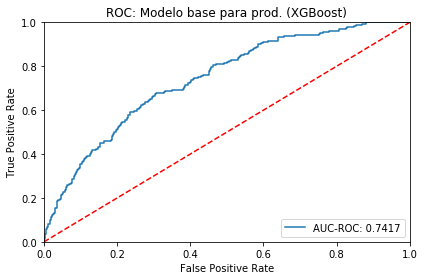

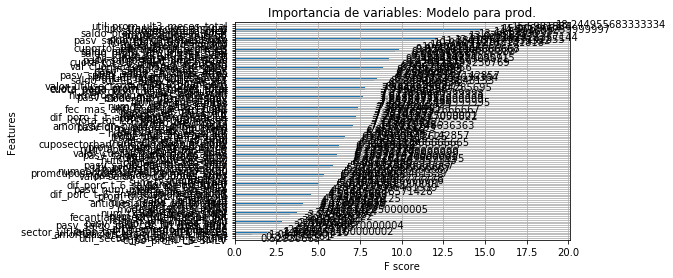

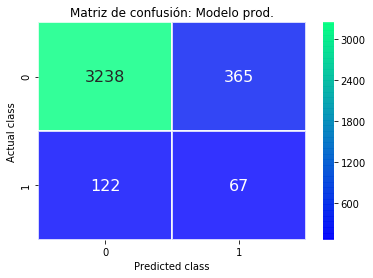

AUC-ROC: 74.17
Precision: 15.51
Sensibilidad (Recall): 35.45
Especificidad: 89.87
Kappa (train): 35.01
Kappa (test): 15.73
Accuracy Rate (train): 89.62
Accuracy Rate (test): 87.16
Var.Target Rate (train): 4.84
Var.Target Rate (test): 4.98
Var.Target Rate (total): 4.88


In [32]:
print('\nModelo '
          + title + ': AUC Score XGBoost: %f' % xgb_roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, probab_xgb[:, 1])

plot_ROC(fpr, tpr, title='ROC: Modelo base para '
             + title + ' (XGBoost)', auc=xgb_roc_auc)

xgb.plot_importance(
           xgb_class,
           importance_type='gain',
           title='Importancia de variables: Modelo para ' + title
           )

th = 0.1
y_test_pred = (probab_xgb[:, 1]>th).astype(int)
y_train_pred = (xgb_class.predict_proba(x_train)[:, 1]>th).astype(int)

cm=confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(
                cm,
                title='Matriz de confusión: Modelo ' + title
                )

print( 'AUC-ROC:', round(xgb_roc_auc*100,2) )
print( 'Precision:', round(precision_score(y_test, y_test_pred)*100,2) )
print( 'Sensibilidad (Recall):', round(recall_score(y_test, y_test_pred)*100,2) )
print( 'Especificidad:', round(cm[0,0]/cm[0,:].sum()*100,2) )
print( 'Kappa (train):', round(cohen_kappa_score(y_train, y_train_pred)*100,2) )
print( 'Kappa (test):', round(cohen_kappa_score(y_test,y_test_pred)*100,2) )
print( 'Accuracy Rate (train):', round(accuracy_score(y_train, y_train_pred)*100,2) )
print( 'Accuracy Rate (test):', round(accuracy_score(y_test, y_test_pred)*100,2) )
print( 'Var.Target Rate (train):', round(y_train.sum()/y_train.shape[0]*100,2) )
print( 'Var.Target Rate (test):', round(y_test.sum()/y_test.shape[0]*100,2) )
print( 'Var.Target Rate (total):', round(label_encoded_y.sum()/label_encoded_y.shape[0]*100,2) )

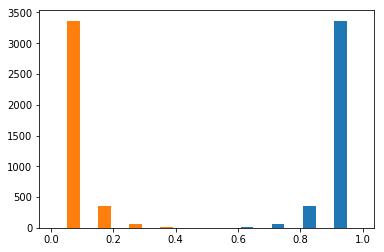

In [33]:
plt.hist(probab_xgb)
plt.show()

In [34]:
#Importance variable
importance = xgb_class.feature_importances_
variables = X.columns
var_imp = pd.concat([pd.Series(variables.values), pd.Series(importance)], axis=1)

importance = model.feature_importances_
variables = X.columns
var_imp = pd.concat([pd.Series(variables.values), pd.Series(importance)], axis=1)

In [35]:
var_imp.columns = ['Features', 'Score']
var_imp.sort_values(by='Score', ascending=False)

,Features,Score
180,util_prom_ult3_meses_total,0.021991
219,tipo_transaccion_ahr_cat,0.018801
160,saldo_prom_LB_SMLV,0.018088
0,acep_oferta_prev,0.017924
162,saldo_prom_ult3_meses_total,0.017513
4,amortizacion_min_LB,0.016466
193,valor_saldo_sr_smlv,0.015710
130,prom_prop_desembolso,0.015672
114,pasv_saldo_max_fin_mes_smlv,0.014709
84,num_tx_ult_6meses_ahr,0.013717


In [36]:
var_imp = var_imp[var_imp.Score > 0]
features = var_imp.Features
var_imp
#features

,Features,Score
0,acep_oferta_prev,0.017924
1,acierta_a_financiero,0.009898
4,amortizacion_min_LB,0.016466
6,amortizacion_prom_LB,0.011858
7,amortizacion_prom_LB_ult3_meses,0.002302
8,amortizacion_prom_LB_ult9_meses,0.008614
13,antiguedad_tot_conlibranza,0.005012
15,cuota_max_LB_SMLV,0.008278
16,cuota_max_tot_SMLV,0.008863
17,cuota_mercado_smlv,0.007307


In [37]:
var_num = pd.DataFrame(var_numericas)
var_num.columns = ['Features']
features_escogidas = pd.DataFrame(features)
print(var_num.shape)
print(features_escogidas.shape)

(199, 1)
(119, 1)


In [38]:
features_escogidas

,Features
0,acep_oferta_prev
1,acierta_a_financiero
4,amortizacion_min_LB
6,amortizacion_prom_LB
7,amortizacion_prom_LB_ult3_meses
8,amortizacion_prom_LB_ult9_meses
13,antiguedad_tot_conlibranza
15,cuota_max_LB_SMLV
16,cuota_max_tot_SMLV
17,cuota_mercado_smlv


In [39]:
result = pd.merge(var_num,
                  features_escogidas,
                  on='Features')
#                   left_on='Vars', 
#                   right_on='Features')
features_final = result.Features
features_final

0                         acep_oferta_prev
1                     acierta_a_financiero
2                      amortizacion_min_LB
3                     amortizacion_prom_LB
4          amortizacion_prom_LB_ult3_meses
5          amortizacion_prom_LB_ult9_meses
6               antiguedad_tot_conlibranza
7                        cuota_max_LB_SMLV
8                       cuota_max_tot_SMLV
9                       cuota_mercado_smlv
10        cuota_paga_prom_ult3_meses_total
11        cuota_paga_prom_ult7_meses_total
12                      cuota_prom_LB_SMLV
13                     cuota_prom_tot_SMLV
14                       cuota_tot_LB_SMLV
15            cuota_tot_LB_SMLV_ult3_meses
16            cuota_tot_LB_SMLV_ult8_meses
17                      cuota_tot_tot_SMLV
18                        cupo_max_LB_SMLV
19                         cupo_mercadodif
20                       cupo_prom_LB_SMLV
21                      cupo_prom_tot_SMLV
22                        cupo_tot_LB_SMLV
23         

In [40]:
df_var_num_finales = mdt_v0[features_final]
#df_var_num_finales.shape

In [41]:
mdt_v0.acep_oferta_prev.value_counts()

0.0    5034
Name: acep_oferta_prev, dtype: int64

In [42]:
# Correlaciones

data = df_var_num_finales

corr = data.corr()
corr

,acep_oferta_prev,acierta_a_financiero,amortizacion_min_LB,amortizacion_prom_LB,amortizacion_prom_LB_ult3_meses,amortizacion_prom_LB_ult9_meses,antiguedad_tot_conlibranza,cuota_max_LB_SMLV,cuota_max_tot_SMLV,cuota_mercado_smlv,cuota_paga_prom_ult3_meses_total,cuota_paga_prom_ult7_meses_total,cuota_prom_LB_SMLV,cuota_prom_tot_SMLV,cuota_tot_LB_SMLV,cuota_tot_LB_SMLV_ult3_meses,cuota_tot_LB_SMLV_ult8_meses,cuota_tot_tot_SMLV,cupo_max_LB_SMLV,cupo_mercadodif,cupo_prom_LB_SMLV,cupo_prom_tot_SMLV,cupo_tot_LB_SMLV,cupo_tot_LB_SMLV_ult3_meses,cupo_tot_LB_SMLV_ult9_meses,cuposectorbancario_sin_popular_smlv,dias_desde_ult_tx_ahr,dias_desde_ult_tx_cdt,dias_desde_ult_tx_pasv,dif_porc_t_1_amortizacion_prom_LB,dif_porc_t_6_amortizacion_prom_LB,dif_porc_t_6_saldo_tot_tot_SMLV,fec_mas_anti_aper_tdc_sin_popu,fecantiapersectorbancasinpopu,lag_t_1_saldo_tot_LB_SMLV,max_cupo_tdc_sin_populardif,max_dias_procesamiento,meses_ultim_aper_LB,num_aper_ultim_12meses_LB,num_lib_solicitadas,num_meses_ult_camp,num_no_aceptado,num_tx_ult_1mes_ahr,num_tx_ult_1mes_cdt,num_tx_ult_2meses_ahr,num_tx_ult_2meses_cdt,num_tx_ult_2meses_pasv,num_tx_ult_3meses_ahr,num_tx_ult_4meses_ahr,num_tx_ult_4meses_cdt,num_tx_ult_4meses_pasv,num_tx_ult_6meses_ahr,num_tx_ult_6meses_pasv,numero_creditos_cf,numero_obligaciones_activasdif,numoblvigensectorbancasin_popu,pasv_antig_total,pasv_dias_desde_ultima_trans,pasv_num_ctas_vig_tot,pasv_num_meses_ult_apertura,pasv_saldo_ca_1mes_atras,pasv_saldo_ca_3mes_atras,pasv_saldo_ca_6mes_atras,pasv_saldo_ca_fin_mes_smlv,pasv_saldo_cc_fin_mes_smlv,pasv_saldo_max_fin_mes_smlv,pasv_saldo_min_ca_fin_mes_smlv,pasv_saldo_min_cdt_fin_mes_smlv,pasv_saldo_min_fin_mes_smlv,pasv_saldo_total_3mes_atras,pasv_saldo_total_6mes_atras,porcentaje_utilizacion,prom_dias_procesamiento,prom_monto_aprobado,prom_monto_desembolsado,prom_monto_novado,prom_n_cuotas,prom_prop_desembolso,prom_tasa,prom_valor_cuota,promcuposectorbancasin_popular_smlv,quanto_mod,rango_2,rango_4,saldo_max_LB_SMLV,saldo_prom_LB_SMLV,saldo_prom_ult3_meses_total,saldo_prom_ult6_meses_total,saldo_prom_ult7_meses_total,saldo_tot_LB_SMLV_ult7_meses,saldo_tot_tot_SMLV,sum_tx_linea_ahr,sum_tx_linea_pasv,sum_tx_nolinea_ahr,sum_tx_nolinea_pasv,tiene_sectorreal,util_prom_ult3_meses_total,util_prom_ult6_meses_total,util_prom_ult9_meses_total,util_sector_banca_sin_popular,val_cuo_sector_banca_sin_popu,valor_cuotas_codeudores_smlv,valor_cuotas_sr_smlv,valor_inicial_cbdif,valor_inicial_cf_smlv,valor_saldo_cbdif,valor_saldo_codeudores_smlv,valor_saldo_sr_smlv,valor_saldo_srdif,valor_utilisectorbancasin_popu_smlv,valor_utilizado_smlv,valor_utilizadodif
acep_oferta_prev,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acierta_a_financiero,NaN,1.000000,0.199208,0.202096,0.201187,0.182859,0.201238,0.085476,0.085340,0.061004,0.204249,0.190314,0.086022,0.086397,0.078458,0.084427,0.090789,0.078268,0.043433,-0.095572,0.044164,0.044434,0.039580,0.047378,0.057213,0.045789,-0.028320,-0.032576,-0.026008,-0.092334,0.014019,-0.090919,0.474911,0.020182,-0.023008,0.000082,0.014093,0.202010,-0.165095,0.042685,0.051151,0.034212,0.011739,0.068616,-0.000080,0.101431,0.000101,-0.007607,-0.007766,0.067198,-0.007626,-0.006620,-0.006546,0.129746,-0.150836,0.023353,0.191241,-0.017415,-0.033356,0.171360,0.061341,0.054942,0.057284,0.063016,0.070923,0.067807,0.084622,0.115879,0.084827,0.062073,0.063979,-0.284763,0.000323,0.047282,0.039966,0.016420,-0.119045,-0.013643,0.070977,0.088379,0.044918,0.351264,0.122424,0.286634,-0.027329,-0.027080,-0.019491,-0.011338,-0.008887,-0.007863,-0.028204,0.020740,0.021781,0.012031,0.012180,-0.134539,-0.201

In [43]:
var_finales = [
#'acierta_a_financiero',#
'amortizacion_min_LB',#
'cuota_max_LB_SMLV',#
# 'cupo_mercadodif',
# 'cuposectorbancario_sin_popular_smlv',
'dias_desde_ult_tx_ahr',#
# 'dias_desde_ult_tx_cdt',
# 'dif_porc_t_1_amortizacion_prom_LB',
# 'dif_porc_t_6_amortizacion_prom_LB',
# 'dif_porc_t_6_saldo_tot_tot_SMLV',
# 'fec_mas_anti_aper_tdc_sin_popu',
# 'max_cupo_tdc_sin_populardif',
# 'max_dias_procesamiento',
# 'num_aper_ultim_12meses_LB',
'num_lib_solicitadas',#
#'num_meses_ult_camp',#
'num_no_aceptado',#
'num_tx_ult_1mes_ahr',#
# 'num_tx_ult_1mes_cdt',
# 'num_tx_ult_2meses_cdt',
# 'numero_creditos_cf',
'numero_obligaciones_activasdif',#
'pasv_antig_total',#
# 'pasv_dias_desde_ultima_trans',
# 'pasv_num_ctas_vig_tot',
'pasv_saldo_ca_1mes_atras',#
'porcentaje_utilizacion',#
'prom_monto_novado',#
'prom_n_cuotas',#
# 'prom_tasa',
'quanto_mod',#
# 'rango_2',
# 'rango_4',
'sum_tx_linea_ahr',#
# 'tiene_sectorreal',
'valor_cuotas_codeudores_smlv',#
# 'valor_cuotas_sr_smlv',
# 'valor_inicial_cf_smlv',
# 'valor_saldo_cbdif',
# 'valor_saldo_srdif',
'valor_utilizado_smlv',#
# 'valor_utilizadodif'
]

In [ ]:
var_finales = [
'amortizacion_min_LB',#
'cuota_max_LB_SMLV',#
'dias_desde_ult_tx_ahr',#
'num_lib_solicitadas',#
'num_no_aceptado',#
'num_tx_ult_1mes_ahr',#
'numero_obligaciones_activasdif',#
'pasv_antig_total',#
'pasv_saldo_ca_1mes_atras',#
'porcentaje_utilizacion',#
'prom_monto_novado',#
'prom_n_cuotas',#
'quanto_mod',#
'sum_tx_linea_ahr',#
'valor_cuotas_codeudores_smlv',#
'valor_utilizado_smlv',#
]

In [44]:
X.fec_mas_anti_aper_tdc_sin_popu.value_counts()

0.0         5531
201903.0     141
200808.0      81
200902.0      80
200611.0      64
200807.0      61
201001.0      59
200604.0      57
200904.0      56
200909.0      55
200805.0      55
200701.0      54
200801.0      53
200608.0      53
200610.0      52
200704.0      51
200705.0      51
200810.0      51
201107.0      51
200709.0      51
200907.0      50
201608.0      50
200702.0      50
200804.0      49
201105.0      48
201108.0      47
201612.0      46
200806.0      46
200910.0      46
200903.0      45
200706.0      45
201011.0      45
201803.0      45
201101.0      44
201805.0      44
200605.0      44
200802.0      44
201411.0      44
201602.0      43
200711.0      43
201003.0      43
201808.0      43
201710.0      42
200912.0      42
200906.0      41
200609.0      41
201707.0      41
201002.0      40
201006.0      40
201007.0      40
201409.0      39
201610.0      39
201701.0      39
201009.0      39
200710.0      39
200603.0      39
200812.0      38
201408.0      38
201611.0      

In [45]:
X2 = X[var_finales]

In [46]:
#Seed for random methods (every result in the code should be reproducible)

SEED = 123

# Test size for train/test split

TEST_SIZE = 0.3

x_train, x_test, y_train, y_test = train_test_split(
        X2,
        label_encoded_y,
        test_size=TEST_SIZE,
        random_state=SEED
        )

xgb_class = xgb.XGBClassifier(n_jobs=-1, seed=SEED)

# x_train.reset_index(drop=True,inplace=True)
# x_test.reset_index(drop=True,inplace=True)
# y_train.reset_index(drop=True,inplace=True)
# y_test.reset_index(drop=True,inplace=True)

title = 'prod.'

xgb_class.fit(x_train, y_train)

preds_xgb = xgb_class.predict(x_test)
probab_xgb = xgb_class.predict_proba(x_test)

xgb_roc_auc = roc_auc_score(y_test, probab_xgb[:, 1])

In [47]:
xgb_class

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=123, silent=None,
       subsample=1, verbosity=1)

In [48]:
x_train.head()

,amortizacion_min_LB,cuota_max_LB_SMLV,dias_desde_ult_tx_ahr,num_lib_solicitadas,num_no_aceptado,num_tx_ult_1mes_ahr,numero_obligaciones_activasdif,pasv_antig_total,pasv_saldo_ca_1mes_atras,porcentaje_utilizacion,prom_monto_novado,prom_n_cuotas,quanto_mod,sum_tx_linea_ahr,valor_cuotas_codeudores_smlv,valor_utilizado_smlv
id_cliente,,,,,,,,,,,,,,,,
351652296419551501,0.00,0.65,13.0,1.0,NaN,43.35,0.00,14.57,0.03,0.31,0.0,96.0,9309000.0,3.0,0.0,10.83
779452298968774501,0.13,0.28,0.0,5.0,1.0,64.96,0.17,224.33,52.46,0.14,790007.2,65.2,4349000.0,4.0,0.0,0.73
234952296387454002,0.67,0.45,5.0,2.0,NaN,11.71,0.00,248.43,0.53,NaN,2871836.0,76.0,4845000.0,6.0,0.0,0.00
153052307460065002,0.00,0.38,8.0,5.0,1.0,8.83,0.00,127.67,1.08,NaN,3420464.2,43.2,3028000.0,5.0,0.0,0.00
351652306565525301,0.01,0.35,2.0,5.0,1.0,3.00,0.25,183.63,0.37,0.34,5615258.4,59.6,3192000.0,3.0,0.0,1.60


In [49]:
y_train

array([0, 0, 0, ..., 0, 0, 0])


Modelo prod.: AUC Score XGBoost: 0.731400


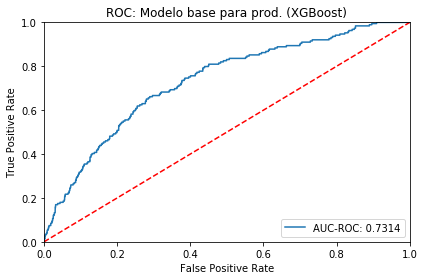

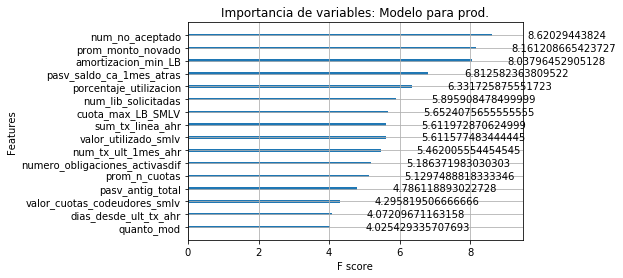

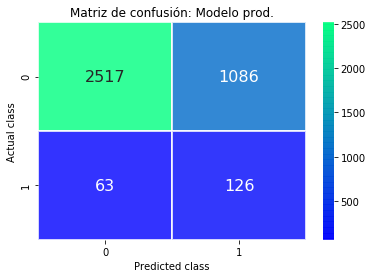

AUC-ROC: 73.14
Precision (train): 12.66
Precision (test): 10.4
Sensibilidad (Recall) (train): 85.98
Sensibilidad (Recall) (test): 66.67
Especificidad: 69.86
Kappa (train): 14.89
Kappa (test): 10.25
Accuracy Rate (train): 70.62
Accuracy Rate (test): 69.7
Var.Target Rate (train): 4.84
Var.Target Rate (test): 4.98
Var.Target Rate (total): 4.88


In [50]:
print('\nModelo '
          + title + ': AUC Score XGBoost: %f' % xgb_roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, probab_xgb[:, 1])

plot_ROC(fpr, tpr, title='ROC: Modelo base para '
             + title + ' (XGBoost)', auc=xgb_roc_auc)

xgb.plot_importance(
           xgb_class,
           importance_type='gain',
           title='Importancia de variables: Modelo para ' + title
           )

th = 0.05
y_test_pred = (probab_xgb[:, 1]>th).astype(int)
y_train_pred = (xgb_class.predict_proba(x_train)[:, 1]>th).astype(int)

cm=confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(
                cm,
                title='Matriz de confusión: Modelo ' + title
                )

print( 'AUC-ROC:', round(xgb_roc_auc*100,2) )
print( 'Precision (train):', round(precision_score(y_train, y_train_pred)*100,2) )
print( 'Precision (test):', round(precision_score(y_test, y_test_pred)*100,2) )
print( 'Sensibilidad (Recall) (train):', round(recall_score(y_train, y_train_pred)*100,2) )
print( 'Sensibilidad (Recall) (test):', round(recall_score(y_test, y_test_pred)*100,2) )
print( 'Especificidad:', round(cm[0,0]/cm[0,:].sum()*100,2) )
print( 'Kappa (train):', round(cohen_kappa_score(y_train, y_train_pred)*100,2) )
print( 'Kappa (test):', round(cohen_kappa_score(y_test,y_test_pred)*100,2) )
print( 'Accuracy Rate (train):', round(accuracy_score(y_train, y_train_pred)*100,2) )
print( 'Accuracy Rate (test):', round(accuracy_score(y_test, y_test_pred)*100,2) )
print( 'Var.Target Rate (train):', round(y_train.sum()/y_train.shape[0]*100,2) )
print( 'Var.Target Rate (test):', round(y_test.sum()/y_test.shape[0]*100,2) )
print( 'Var.Target Rate (total):', round(label_encoded_y.sum()/label_encoded_y.shape[0]*100,2) )

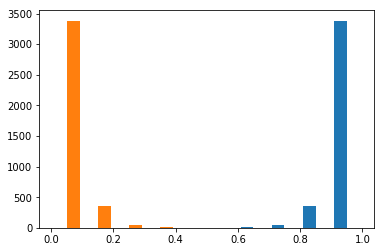

In [51]:
plt.hist(probab_xgb)
plt.show()

## SHAP VALUE

In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(xgb_class).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, x_train)

In [ ]:
distribucion_dias = X.dias_desde_ult_tx_ahr.value_counts()
distribucion_dias = pd.DataFrame(distribucion_dias)
distribucion_dias = distribucion_dias.reset_index()

In [ ]:
plt.hist(X2['acierta_a_financiero'])
plt.show()

In [ ]:
distribucion_dias.order

## Variables vs. Score

In [ ]:
# avg features by probability buckets

# Add probability output as column

x2 = x_test.reset_index()
x2.drop(['id_cliente'], axis=1, inplace=True)

prob = pd.DataFrame(probab_xgb[:, 1])
prob.columns = ['pred_prob']
#prob = pd.DataFrame(y_pred[:, 1])

output = x2.join(prob, how='inner')

# Create probability bucket

#            output['prob_buckets'] = output.pred_prob.apply(
#                    lambda x: int(x * 10)
#                    )
##            output.drop('prob_buckets',axis=1,inplace=True)

output['prob_buckets'] = pd.qcut(output['pred_prob'],10,precision=4,duplicates='drop')
            
#            output[cols] = output[cols].apply(
#            lambda x: [
#                    y if ((y >= x.quantile(0.05)) and (y <= x.quantile(0.95))) 
#                      else (x.quantile(0.05) if (np.abs(y)-np.abs(min(x))) < (np.abs(max(x))-np.abs(y)) else x.quantile(0.95)) for y in x
#                      ]
#                      )

# Group by probability bucket taking the average of all features
            
gb = output.groupby('prob_buckets').mean()
gb.drop('pred_prob',axis=1,inplace=True)            

n_features = gb.shape[1]-1
n_buckets = gb.shape[0]
        
# Plotting results

#%matplotlib auto
plt.figure(figsize=(14, 10))

for idx, _ in enumerate(gb):
    plt.subplot(
                int(np.sqrt(n_features)) + 1,
                int(np.sqrt(n_features)) + 1, idx + 1
                )
    plt.rc('font', size=10)
    plt.plot(range(n_buckets), gb[_], '-o')
    plt.title(_)
    plt.grid(alpha=0.4)
    plt.tight_layout()

# Cross validation

In [ ]:
# Seed for random methods (every result in the code should be reproducible)

SEED = 123

# Test size for train/test split

TEST_SIZE = 0.3

# Explore performance of baseline model in more depth (learning curve and
# average of kfolds to improve stability of results)

print('\nTraining baseline model in kfolds (see output plots)')

# Plotting learning curve

for x, y, title in zip(
        [X2],
        [pd.Series(label_encoded_y)],
        ['nba_empresas']
        ):
    # Iterate for cobranza

    if x is None:
        # Skip if one case is not being considered

        continue

    # Train/test split

    x_train, x_test, y_train, y_test = train_test_split(
            x,
            y,
            test_size=TEST_SIZE,
            random_state=SEED
            )
    
    x_train.reset_index(drop=True,inplace=True)
    x_test.reset_index(drop=True,inplace=True)
    #y_train.reset_index(drop=True,inplace=True)
    #y_test.reset_index(drop=True,inplace=True)

    xgb_class_cs = xgb.XGBClassifier(n_jobs=-1, seed=SEED)

    # Define cross validation

    kfold = StratifiedKFold(n_splits=5)

    # Learning curve

    plot_learning_curve(
            xgb_class_cs,
            'Curva de aprendizaje XGBoost: Modelo base para ' + title,
            x_train,
            y_train,#.loc[:,var_target],
            cv=kfold
            )

    # Plotting ROC curve for several kfolds

    plot_ROC_kfolds(
            xgb_class_cs,
            x_train,
            y_train,#.loc[:,var_target],
            kfold,
            'Curvas ROC para kfolds: Modelo base para ' + title
            )

## Guardar modelo

In [ ]:
import pickle

path = '/mnt/work/CU_adquisicionTC/Notebooks/creacion_modelo/ModeloPreAprobados_convars.pkl'
with open(path, 'wb') as f:
    pickle.dump(xgb_class, f)

## Tablas de validación

In [53]:
x_train.shape

(8847, 16)

In [54]:
x_test.shape

(3792, 16)

In [55]:
#x_train, x_test, y_train, y_test

#Test
X2['probs'] = xgb_class.predict_proba(X2)[:, 1]
X2['decil_probs']=pd.qcut(X2['probs'].rank(method='first'),5, labels=False)

pd.crosstab(X2['decil_probs'],label_encoded_y, margins=False)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


col_0,0,1
decil_probs,,
0,2514,14
1,2502,26
2,2481,46
3,2406,122
4,2119,409


In [56]:
X2.groupby('decil_probs')[['probs']].min()

,probs
decil_probs,
0,0.000938
1,0.012560
2,0.024304
3,0.041160
4,0.074228


In [57]:
X2.groupby('decil_probs')[['probs']].max()

,probs
decil_probs,
0,0.012560
1,0.024303
2,0.041160
3,0.074187
4,0.619235


In [58]:
#x_train, x_test, y_train, y_test

#Test
x_train['probs'] = xgb_class.predict_proba(x_train)[:, 1]
x_train['decil_probs']=pd.qcut(x_train['probs'].rank(method='first'),5, labels=False)

pd.crosstab(x_train['decil_probs'],y_train, margins=False)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


col_0,0,1
decil_probs,,
0,1769,1
1,1758,11
2,1745,24
3,1694,75
4,1453,317


In [59]:
x_train.groupby('decil_probs')[['probs']].min()

,probs
decil_probs,
0,0.000938
1,0.012683
2,0.024539
3,0.041160
4,0.074901


In [60]:
x_train.groupby('decil_probs')[['probs']].max()

,probs
decil_probs,
0,0.012676
1,0.024537
2,0.041160
3,0.074890
4,0.619235


In [61]:
#x_train, x_test, y_train, y_test

#Test
x_test['probs'] = xgb_class.predict_proba(x_test)[:, 1]
x_test['decil_probs']=pd.qcut(x_test['probs'].rank(method='first'),5, labels=False)

pd.crosstab(x_test['decil_probs'],y_test, margins=False)

/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


col_0,0,1
decil_probs,,
0,747,12
1,742,16
2,736,22
3,710,48
4,668,91


In [62]:
x_test.groupby('decil_probs')[['probs']].min()

,probs
decil_probs,
0,0.001121
1,0.012206
2,0.023834
3,0.041186
4,0.072614


In [63]:
x_test.groupby('decil_probs')[['probs']].max()

,probs
decil_probs,
0,0.012195
1,0.023813
2,0.041180
3,0.072577
4,0.365485


In [ ]:
X2.groupby('decil_probs')[['probs']].min()

In [ ]:
X2.groupby('decil_probs')[['probs']].max()

In [ ]:
X2['decil_acierta']=pd.qcut(X2['acierta_a_financiero'].rank(method='first'),10, labels=False)

In [ ]:
pd.crosstab(X2['decil_probs'],X2['decil_acierta'], margins=False)

In [ ]:
X2['decil_num_meses_ult_camp']=pd.qcut(X2['num_meses_ult_camp'].rank(method='first'),10, labels=False)

In [ ]:
pd.crosstab(X2['decil_probs'],X2['decil_num_meses_ult_camp'], margins=False)

In [ ]:
plt.hist(X2['num_meses_ult_camp'])
plt.show()

In [ ]:
plt.hist(X2['acierta_a_financiero'])
plt.show()

In [ ]:
X2.head() #acierta_a_financiero decil

In [ ]:
X2.shape

In [ ]:
plt.hist(X2['probs'])
plt.show()

In [ ]:
X2['decil_acierta'].value_counts()

In [ ]:
# Testing tree
my_tree(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
mdt_v0

In [ ]:
num_meses_ult_camp

In [ ]:
mdt_v0['decil_num_meses_ult_camp']=pd.qcut(mdt_v0['num_meses_ult_camp'].rank(method='first'),10, labels=False)

In [ ]:
pd.crosstab(mdt_v0['30first_use'],mdt_v0['decil_num_meses_ult_camp'], margins=False)

In [ ]:
1-X2.count()/len(X2)

In [ ]:
falso = mdt_v0[mdt_v0['30first_use'] == 0]

In [ ]:
verdadero = mdt_v0[mdt_v0['30first_use'] == 1]

In [ ]:
plt.hist(mdt_v0['num_meses_ult_camp'])
plt.show()

In [ ]:
plt.hist(falso['num_meses_ult_camp'])
plt.show()

In [ ]:
plt.hist(verdadero['num_meses_ult_camp'])
plt.show()